# Постановка задачи
Нужно построить модель, которая сможет по входящим параметрам потока (число Маха $M_{\infty}$ и угол атаки $\alpha$) предсказать значения коэффициентов сопротивления $C_x$ и подъёмной силы $C_y$.  
Проверка качества моддели будет производиться отдельно по каждой величине.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# для работы с файлами
import glob

# для проверки суррогатных моделей
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# для создания моих суррготаных моделей
import MY_SOLVERS as mysol

# для сохранения и загрузки суррогатных моделей
import joblib

# для отслеживания прогресса
from tqdm import tqdm

from sklearn.utils.validation import check_array

# Чтение данных

In [3]:
regimes = (pd.read_csv("./data/regimes.csv")).drop(['Num'],axis=1)
total_FC = pd.DataFrame(columns=['Cx', 'Cy'], data=np.zeros((regimes.shape[0],2))) #FC - force coefficient

files = glob.glob("results/*_*_*")
files.sort()
for i,path in tqdm(enumerate(files)):
    f = open(path, mode='r')

    l = f.readlines()[22]
    sep_words = l.split()

    total_FC.iloc[i][0] = float(sep_words[-3])
    total_FC.iloc[i][1] = float(sep_words[-2])

    f.close()

64it [00:00, 1621.06it/s]


In [4]:
regimes

,M,alpha
0,0.94648,-3.71875
1,0.83867,-2.40625
2,0.81289,5.84375
3,0.84102,3.59375
4,0.89727,2.65625
...,...,...
59,0.85273,4.34375
60,0.82930,0.78125
61,0.85039,-3.34375
62,0.89258,4.90625


In [5]:
total_FC

,Cx,Cy
0,0.083398,-0.298906
1,0.024050,-0.136088
2,0.080494,0.784640
3,0.046048,0.701913
4,0.043631,0.510899
...,...,...
59,0.060453,0.723859
60,0.021536,0.316106
61,0.035199,-0.238177
62,0.078851,0.708251


# Оценка качества модели

In [7]:
def CxCy_quality(CxCy_true, CxCy_pred, need_print=True):
    """
    Считает ошибку предсказания по Cx и по Cy
    
    Parameters
    ----------
    CxCy_true : DataFrame or numpy.array, shape=(Nsample, 2)
        Правильные значения коэффициентов. Каждая строчка содержит значение Cx и Cy на каком-то режиме
    CxCy_pred : DataFrame or numpy.array, shape=(Nsample, 2)
        Предсказанные значения коэффициентов. Каждая строчка содержит значение Cx и Cy на каком-то режиме
    need_print : bool, optional
        Флаг, сигнализирующий о необходимости выводить информацию об ошибках предсказания
    
    Returns
    -------
    RMSE_Cx : float
        Корень из среднеквадратичной ошибки предсказания коэффициента Cx
    RMSE_Cy : float
        Корень из среднеквадратичной ошибки предсказания коэффициента Cy
    MAE_Cx : float
        Средний модуль ошибки предсказания коэффициента Cx
    MAE_Cy : float
        Средний модуль ошибки предсказания коэффициента Cy
    """
    
    CxCy_true = check_array(CxCy_true)
    CxCy_pred = check_array(CxCy_pred)
    # теперь массивы являются numpy-массивами
    
    RMSE_Cx, RMSE_Cy = np.sqrt(np.mean((CxCy_pred - CxCy_true)**2, axis=0))
    MAE_Cx, MAE_Cy = np.mean(np.abs(CxCy_pred - CxCy_true), axis=0)
    
    if need_print:
        print(f"RMSE_Cx = {RMSE_Cx}")
        print(f"RMSE_Cy = {RMSE_Cy}")
        print(f"MAE_Cx = {MAE_Cx}")
        print(f"MAE_Cy = {MAE_Cy}")
    
    return RMSE_Cx, RMSE_Cy, MAE_Cx, MAE_Cy

# Train / test split

In [6]:
# Выделим тестовые случаи, а остальные оставим для обучения

# Способ 1
# number_of_test_regime = [63]

# train_FC = total_FC.drop(number_of_test_regime, axis=0)
# test_FC = total_FC.iloc[number_of_test_regime]

# train_regimes = regimes.drop(number_of_test_regime,axis=0)
# test_regimes = regimes.iloc[number_of_test_regime]
# test_regimes_index = test_regimes.index.to_numpy()


# Способ 2
train_regimes, test_regimes, train_FC, test_FC = train_test_split(regimes, total_FC,test_size=8.0/64)

# выцепим нужную информацию для тестирования
test_regimes_index = test_regimes.index.to_numpy()

In [7]:
test_regimes

,M,alpha
41,0.90898,2.28125
32,0.83164,6.03125
35,0.80586,-2.96875
15,0.92773,7.34375
20,0.85977,3.21875
6,0.87852,6.21875
39,0.88555,6.96875
53,0.90430,-2.03125


# Первая рабочая модель

In [8]:
kw_args_for_sm = {
    'print_global' : False,
}
sm_names = ["KRG", "KRG"]
coef_for_predict = ["Cx", "Cy"]

In [9]:
model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                             list_kw_args=kw_args_for_sm, 
                             coef_for_predict=coef_for_predict, 
                             debug=True)

CxCy_PREDICTOR initing...
	sm_names = ['KRG', 'KRG']
	list_kw_args = [{'print_global': False}, {'print_global': False}]
	coef_for_predict = ['Cx', 'Cy'], number_of_predict_params = 2


In [10]:
model.fit(regimes=train_regimes, target=train_FC)

CxCy_PREDICTOR fitting...
	regimes.shape = (56, 2)
	target.shape = (56, 2)


In [11]:
pred_FC = model.predict(regimes=test_regimes)

CxCy_PREDICTOR predicting...
	regimes.shape = (8, 2)


In [12]:
pred_FC

,Cx,Cy
0,0.042210,0.410393
1,0.086213,0.781159
2,0.019549,-0.159611
3,0.143282,0.914450
4,0.043654,0.656825
5,0.100384,0.793661
6,0.116624,0.801822
7,0.038366,-0.055602


In [13]:
test_FC

,Cx,Cy
41,0.041490,0.417826
32,0.085110,0.767746
35,0.021295,-0.170663
15,0.147154,0.915530
20,0.043864,0.648972
6,0.099622,0.773008
39,0.116034,0.801935
53,0.038145,-0.061454


In [14]:
errors = CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=True)

RMSE_Cx = 0.0016123832695503324
RMSE_Cy = 0.010493714901546712
MAE_Cx = 0.0011530371748868212
MAE_Cy = 0.008430999217891581


# Организация цикла перебора и выбора наилучшей модели

## Попробуем разные модели без подбора гипер-параметров

In [15]:
import itertools

In [16]:
l = ["LS", "KRG", "RBF"]
# l = ["LS", "KRG"]
prod = itertools.product(l, repeat=2)
list_of_sm_names = []
list_of_sm_names_str = []
for p in prod:
    list_of_sm_names.append(list(p))

for smn in list_of_sm_names:
    list_of_sm_names_str.append(smn[0]+'_'+smn[1])

In [17]:
list_of_sm_names

[['LS', 'LS'],
 ['LS', 'KRG'],
 ['LS', 'RBF'],
 ['KRG', 'LS'],
 ['KRG', 'KRG'],
 ['KRG', 'RBF'],
 ['RBF', 'LS'],
 ['RBF', 'KRG'],
 ['RBF', 'RBF']]

In [18]:
list_of_sm_names_str

['LS_LS',
 'LS_KRG',
 'LS_RBF',
 'KRG_LS',
 'KRG_KRG',
 'KRG_RBF',
 'RBF_LS',
 'RBF_KRG',
 'RBF_RBF']

In [19]:
Nsamples = len(list_of_sm_names)
total_errors = []

In [20]:
for i in range(Nsamples):
    kw_args_for_sm = {
        'print_global' : False,
    }
    sm_names = list_of_sm_names[i]
    coef_for_predict = ["Cx", "Cy"]
    
    print()
    print(sm_names)
    model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                                 list_kw_args=kw_args_for_sm, 
                                 coef_for_predict=coef_for_predict, 
                                 debug=False)
    model.fit(regimes=train_regimes, target=train_FC)
    pred_FC = model.predict(regimes=test_regimes)
    
    errors = CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=True)
    total_errors.append(errors)
    print('_________________________')
total_errors = np.array(total_errors)


['LS', 'LS']
RMSE_Cx = 0.021038306324465603
RMSE_Cy = 0.07010872244965222
MAE_Cx = 0.018573939895813095
MAE_Cy = 0.057711730535100335
_________________________

['LS', 'KRG']
RMSE_Cx = 0.021038306324465603
RMSE_Cy = 0.010522115802569456
MAE_Cx = 0.018573939895813095
MAE_Cy = 0.008532142627165007
_________________________

['LS', 'RBF']
RMSE_Cx = 0.021038306324465603
RMSE_Cy = 0.041172184368021746
MAE_Cx = 0.018573939895813095
MAE_Cy = 0.035812966471728276
_________________________

['KRG', 'LS']
RMSE_Cx = 0.0016123832695503324
RMSE_Cy = 0.07010872244965222
MAE_Cx = 0.0011530371748868212
MAE_Cy = 0.057711730535100335
_________________________

['KRG', 'KRG']
RMSE_Cx = 0.0016123832695503324
RMSE_Cy = 0.010522115802569456
MAE_Cx = 0.0011530371748868212
MAE_Cy = 0.008532142627165007
_________________________

['KRG', 'RBF']
RMSE_Cx = 0.0016123832695503324
RMSE_Cy = 0.041172184368021746
MAE_Cx = 0.0011530371748868212
MAE_Cy = 0.035812966471728276
_________________________

['RBF', 'LS']
RM

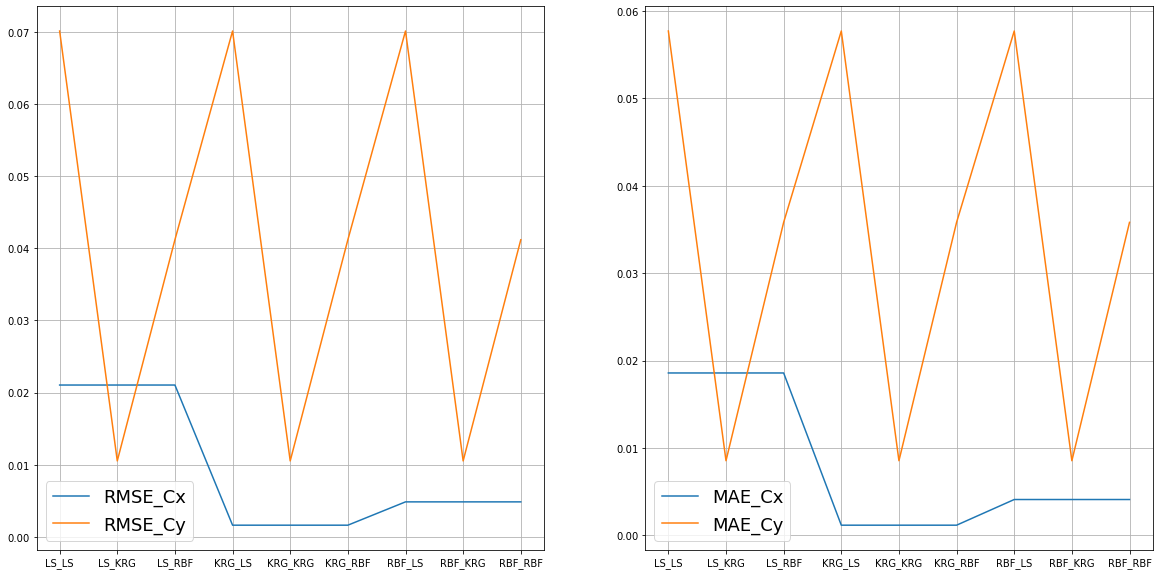

In [21]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(list_of_sm_names_str, total_errors[:,0], label="RMSE_Cx")
plt.plot(list_of_sm_names_str, total_errors[:,1], label="RMSE_Cy")
plt.grid()
plt.legend(fontsize=18)

plt.subplot(1,2,2)
plt.plot(list_of_sm_names_str, total_errors[:,2], label="MAE_Cx")
plt.plot(list_of_sm_names_str, total_errors[:,3], label="MAE_Cy")
plt.grid()
plt.legend(fontsize=18)


лучше всего себя показывает пара `KRG, KRG`

## Для пары `KRG, KRG` попробуем поподбирать гипер-параметры

In [22]:
sm_names = ['KRG', 'KRG']
coef_for_predict = ["Cx", "Cy"]

### Гипер-параметры кригинга

#### noise0 :
Дисперсия шума. По умолчанию `noise0 = 0`, т.е. происходит интерполяция. Если же `noise0 > 0`, то решается задача регрессии. Если `noise0` - список, то он задаёт дисперсии шума в каждой тренировочной точке отдельно. Если же `noise0` - число, то устанавлимаея дисперсия в каждой точке одинакова.

#### eval_noiuse :
Флаг - оценивать ли дисперсию шума. По умалочанию `eval_noiuse = False`, поэтому дисперсия шума берётся из `noise0`. Если же `eval_noise = True`, то дисперсия шума оценивается методом максимального правдоподобия.

#### use_het_noise:
Флаг - делать ли предположение о гетероскедастичности шума.  

__примечание__:  
* __гомоскедастичность__ - это свойство, заключающееся в постоянстве дисперсии (однородность дисперсии случайной величины). Другими словами, если шум гомоскедастичен, то его дисперсия в каждой тренировочной точке одинакова.
* __гетероскедастичность__ - неоднородность дисперсии. Если шум гетероскедастичен, то его дисперсия в каждой тренировочной точке разная.

По умолчанию `use_het_noise = False`. Если `use_het_noise = True`, то надо либо задать дисперсию шума в каждой точке через `noise0`, либо выставить флаг `eval_noiuse = True`.

#### theta0:
Параметр, используемый в корреляционном ядре.  

__примечание__:  
> Формула предсказания методом Кригинга: $\hat{y} = \sum{\beta_i f_i(x)} + Z(x)$, где $f_i(x)$ - это функции тренда, а $Z(x)$ имеет следующее свойство: $cov(Z(x_i),Z(x_j)) = \sigma^2 R(x_i,x_j)$, где $R(x_1,x_2)$ - это ядро корреляции.

По умолчанию `theta0 = 0.1`. Параметр может быть равен либо одному числу, либо списку чисел, длина которого равна размерности проектного пространства.

#### corr:
Функция ядра корреляции. По умолчанию `corr = squar_exp`. Возможные значения: `squar_exp, abs_exp, matern32, matern52`.

#### poly:
Функция тренда. По умолчанию `poly = constant`. Возможные значения: `constant, linear, quadratic`.

In [23]:
train_regimes, test_regimes, train_FC, test_FC = train_test_split(regimes, total_FC,test_size=8.0/64)

# выцепим нужную информацию для тестирования
test_regimes_index = test_regimes.index.to_numpy()

In [24]:
# пробная ячейка : пробуем использовать все гипер-параметры
kw_args_for_sm = {
    'print_global' : False,
    'noise0' : [1e-6],
    'eval_noise' : True,
    'use_het_noise' : True,
    'theta0' : [0.1],
    'corr' : 'squar_exp',
    'poly' : 'constant'
    }
sm_names = ['KRG', 'KRG']
coef_for_predict = ["Cx", "Cy"]

model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                             list_kw_args=kw_args_for_sm, 
                             coef_for_predict=coef_for_predict, 
                             debug=False)
model.fit(regimes=train_regimes, target=train_FC)

pred_FC = model.predict(regimes=test_regimes)
errors = CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=True)

RMSE_Cx = 0.00872580861816944
RMSE_Cy = 0.01272498150856088
MAE_Cx = 0.004007776815927998
MAE_Cy = 0.010355913849915903


In [25]:
# сетка интересующих нас параметров
# возможно, нас будет интересовать другой шум (noise0) или theta0...

noise0_list = [0, 1e-3, 1e-6]
eval_noise_list = [False, True]
use_het_noise_list = [False, True]
theta0_list = [0.1, 1, 1e-3, 1e-6]
corr_list = ['squar_exp', 'abs_exp', 'matern32', 'matern52']
poly_list = ['constant', 'linear', 'quadratic']

In [ ]:
# ячейка - шаблон, для создания списка из набора аргументов для перебора.
# itertools.product возвращает декартово произведение из входящих списков. 
# Так можно получить все возможные комбинации гипер-параметров


# kw_args_for_sm_list = []
# for el in itertools.product(
#     noise0_list, 
#     eval_noise_list, 
#     use_het_noise_list, 
#     theta0_list, 
#     corr_list, 
#     poly_list
# ):
    
#     kw = {
#     'print_global' : False,
#     'noise0' : [el[0]],
#     'eval_noise' : el[1],
#     'use_het_noise' : el[2],
#     'theta0' : [el[3]],
#     'corr' : el[4],
#     'poly' : el[5],
#     }
#     kw_args_for_sm_list.append(kw)

### Зафиксируем всё, кроме тренда и проверим качество на кросс-валидации

In [26]:
from sklearn.model_selection import KFold

In [40]:
# ячейка, проверяющая как рабоатет метод KFold.split(data). Он возвращает индексы
kf = KFold(n_splits=8)

for train, test in kf.split(regimes):
    train_regimes, test_regimes = regimes.iloc[train], regimes.iloc[test] 
    train_FC, test_FC = total_FC.iloc[train], total_FC.iloc[test]
    
#     print(train_regimes, end='\n\n')
#     print(test_regimes, end='\n\n')
#     print(train_FC, end='\n\n')
#     print(test_FC, end='\n--------------------------------------\n')

In [43]:
kw_args_for_sm_list = []
for el in itertools.product(poly_list):
    kw = {
    'print_global' : False,
    'poly' : el[0],
    }
    kw_args_for_sm_list.append(kw)

In [44]:
kw_args_for_sm_list

[{'print_global': False, 'poly': 'constant'},
 {'print_global': False, 'poly': 'linear'},
 {'print_global': False, 'poly': 'quadratic'}]

In [53]:
n_splits = 8
MEAN_CROSS_ERRS = []

for itrn, kw in enumerate(kw_args_for_sm_list):
    print('\t',kw)    
        
    model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                                 list_kw_args=kw, 
                                 coef_for_predict=coef_for_predict, 
                                 debug=False)
    
    cross_val = KFold(n_splits=n_splits, shuffle=True) #можно использовать другие методы валидации 
    cross_ERRORS = []
    for train, test in cross_val.split(regimes):
        train_regimes, test_regimes = regimes.iloc[train], regimes.iloc[test] 
        train_FC, test_FC = total_FC.iloc[train], total_FC.iloc[test]
        
        model.fit(regimes=train_regimes, target=train_FC)

        pred_FC = model.predict(regimes=test_regimes)
        errors = np.array(CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=False))
        cross_ERRORS.append(errors)
    cross_ERRORS = np.array(cross_ERRORS)
    MEAN_CROSS_ERRS.append(np.mean(cross_ERRORS, axis=0))
    if True:
        print(' |-RMSE_Cx--|-RMSE_Cy--|--MAE_Cx--|--MAE_Cy--|\n _____________________________________________\n',
              cross_ERRORS)
        
        print('MEANS:\n', np.mean(cross_ERRORS, axis=0), 
              end='\n\n|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|\n\n')

	 {'print_global': False, 'poly': 'constant'}
 |-RMSE_Cx--|-RMSE_Cy--|--MAE_Cx--|--MAE_Cy--|
 _____________________________________________
 [[0.00083516 0.01018708 0.0005815  0.00831431]
 [0.00286804 0.05255303 0.00133643 0.03091924]
 [0.00052003 0.0130659  0.0003837  0.00988602]
 [0.00090259 0.03098502 0.00063271 0.02113234]
 [0.00043778 0.01895599 0.00038825 0.01263902]
 [0.00530188 0.03037881 0.004126   0.02317084]
 [0.00110089 0.02161898 0.00087679 0.01341782]
 [0.00170536 0.02773156 0.00120844 0.02222438]]
MEANS:
 [0.00170897 0.02568455 0.00119173 0.01771299]

|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|

	 {'print_global': False, 'poly': 'linear'}
 |-RMSE_Cx--|-RMSE_Cy--|--MAE_Cx--|--MAE_Cy--|
 _____________________________________________
 [[0.00577391 0.04996299 0.00305424 0.0245022 ]
 [0.0012099  0.00931673 0.00092131 0.00596615]
 [0.0007255  0.01173795 0.00063219 0.00937478]
 [0.00059207 0.00923019 0.00049617 0.0073151 ]
 [0.00092    0.01605105 0.00070496 0.01209106]
 [0.

Итак, видно, что лучшие результаты получаются на квадратичном тренде (что и ожидалось)

#### Потренируемся выводить графики

In [55]:
MEAN_CROSS_ERRS = np.array(MEAN_CROSS_ERRS)
MEAN_CROSS_ERRS

array([[0.00170897, 0.02568455, 0.00119173, 0.01771299],
       [0.00190221, 0.01749158, 0.00120121, 0.01114896],
       [0.00085655, 0.01631548, 0.00063046, 0.01018282]])

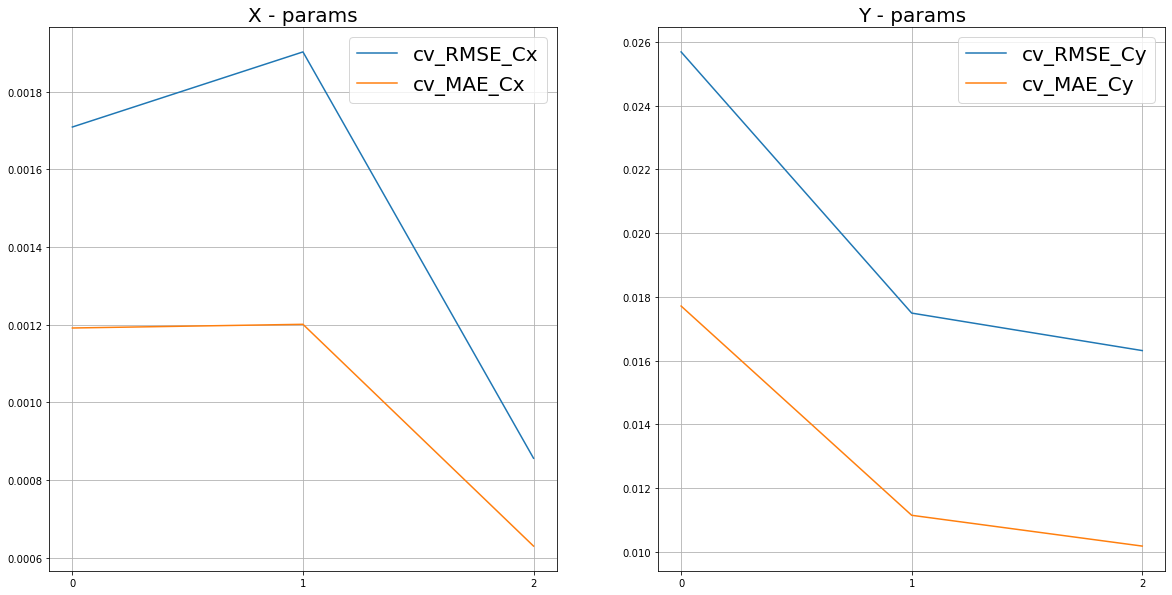

0 - {'print_global': False, 'poly': 'constant'}
1 - {'print_global': False, 'poly': 'linear'}
2 - {'print_global': False, 'poly': 'quadratic'}


In [56]:
x = np.arange(MEAN_CROSS_ERRS.shape[0])
size = 10
plt.figure(figsize=(2*size,size))

plt.subplot(1, 2, 1)
plt.title("X - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[:,0], label='cv_RMSE_Cx')
plt.plot(x, MEAN_CROSS_ERRS[:,2], label='cv_MAE_Cx')
plt.xticks(x)
plt.grid()
plt.legend(fontsize=size*2)

plt.subplot(1, 2, 2)
plt.title("Y - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[:,1], label='cv_RMSE_Cy')
plt.plot(x, MEAN_CROSS_ERRS[:,3], label='cv_MAE_Cy')
plt.xticks(x)
plt.grid()
plt.legend(fontsize=size*2)

plt.show()

for num, hyp_param in zip(x, kw_args_for_sm_list):
    print(f'{num} - {hyp_param}')

### Поварьируем тренд, ядро и параметр theta0. Без регуляризации

In [57]:
kw_args_for_sm_list = []
for el in itertools.product(
    theta0_list, 
    corr_list, 
    poly_list
):
    
    kw = {
    'print_global' : False,
    'theta0' : [el[0]],
    'corr' : el[1],
    'poly' : el[2],
    }
    kw_args_for_sm_list.append(kw)
    
for i, kw in enumerate(kw_args_for_sm_list):
    print(f'[{i}]:{kw}')

[0]:{'print_global': False, 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'constant'}
[1]:{'print_global': False, 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'linear'}
[2]:{'print_global': False, 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'quadratic'}
[3]:{'print_global': False, 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'constant'}
[4]:{'print_global': False, 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'linear'}
[5]:{'print_global': False, 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'quadratic'}
[6]:{'print_global': False, 'theta0': [0.1], 'corr': 'matern32', 'poly': 'constant'}
[7]:{'print_global': False, 'theta0': [0.1], 'corr': 'matern32', 'poly': 'linear'}
[8]:{'print_global': False, 'theta0': [0.1], 'corr': 'matern32', 'poly': 'quadratic'}
[9]:{'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'poly': 'constant'}
[10]:{'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'poly': 'linear'}
[11]:{'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'po

In [59]:
n_splits = 8
MEAN_CROSS_ERRS = []
for itrn, kw in enumerate(kw_args_for_sm_list):
    print(f'{itrn} / {len(kw_args_for_sm_list)-1} : ',kw, end='\r')    
        
    model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                                 list_kw_args=kw, 
                                 coef_for_predict=coef_for_predict, 
                                 debug=False)
    
    cross_val = KFold(n_splits=n_splits, shuffle=True) #можно использовать другие методы валидации 
    ERRORS = []
    for train, test in cross_val.split(regimes):
        train_regimes, test_regimes = regimes.iloc[train], regimes.iloc[test] 
        train_FC, test_FC = total_FC.iloc[train], total_FC.iloc[test]
        
        model.fit(regimes=train_regimes, target=train_FC)

        pred_FC = model.predict(regimes=test_regimes)
        errors = np.array(CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=False))
        ERRORS.append(errors)
    ERRORS = np.array(ERRORS)
    MEAN_CROSS_ERRS.append(np.mean(ERRORS, axis=0))

In [69]:
MEAN_CROSS_ERRS = np.array(MEAN_CROSS_ERRS)
# MEAN_CROSS_ERRS

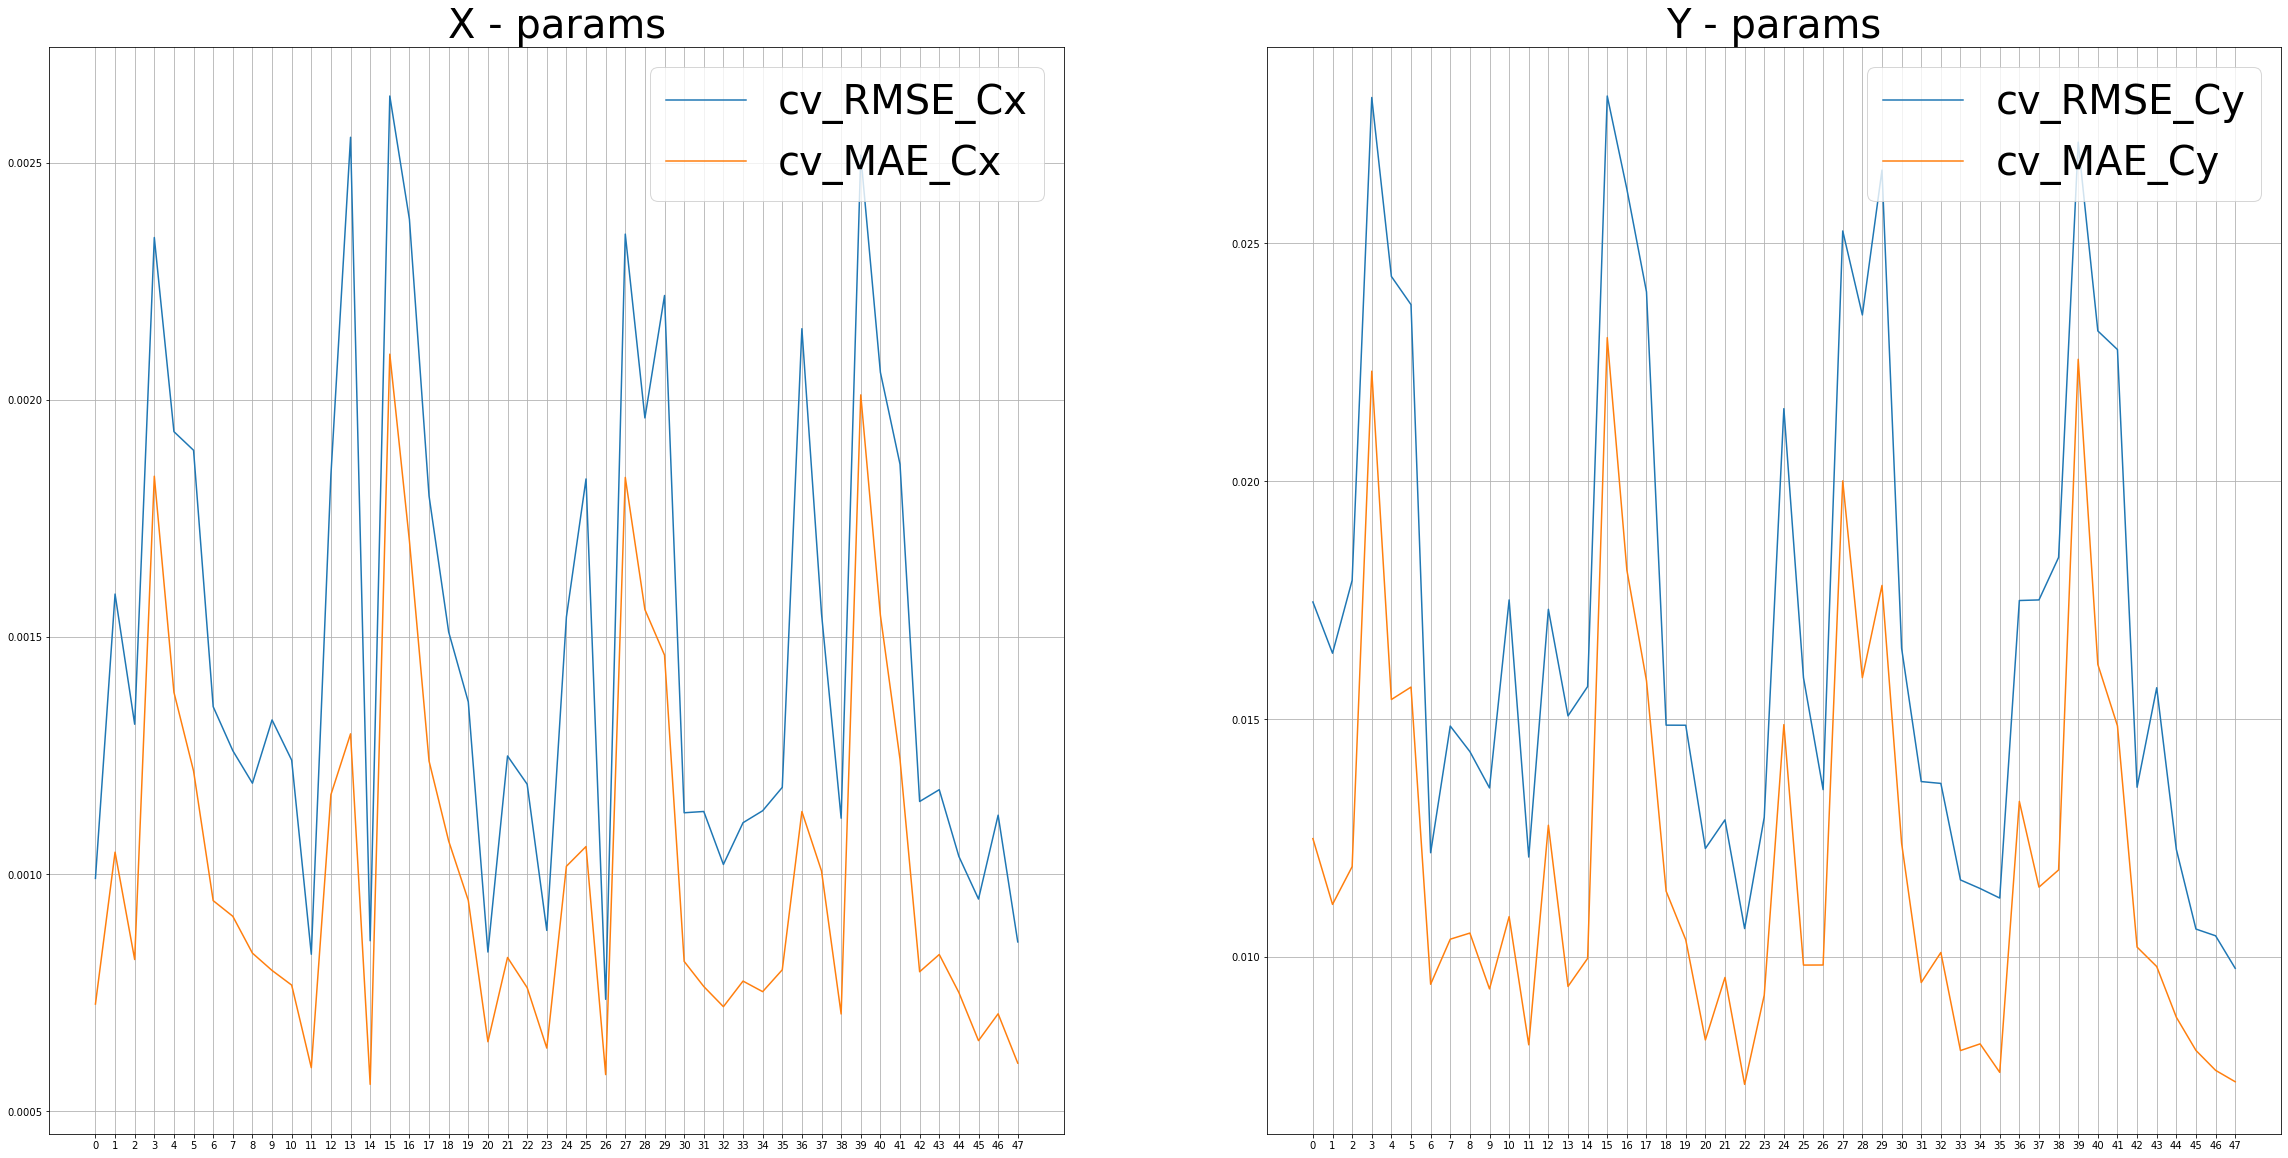

0 - {'print_global': False, 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'constant'}
1 - {'print_global': False, 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'linear'}
2 - {'print_global': False, 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'quadratic'}
3 - {'print_global': False, 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'constant'}
4 - {'print_global': False, 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'linear'}
5 - {'print_global': False, 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'quadratic'}
6 - {'print_global': False, 'theta0': [0.1], 'corr': 'matern32', 'poly': 'constant'}
7 - {'print_global': False, 'theta0': [0.1], 'corr': 'matern32', 'poly': 'linear'}
8 - {'print_global': False, 'theta0': [0.1], 'corr': 'matern32', 'poly': 'quadratic'}
9 - {'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'poly': 'constant'}
10 - {'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'poly': 'linear'}
11 - {'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'po

In [70]:
x = np.arange(MEAN_CROSS_ERRS.shape[0])
size = 20
plt.figure(figsize=(2*size,size))

plt.subplot(1, 2, 1)
plt.title("X - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[:,0], label='cv_RMSE_Cx')
plt.plot(x, MEAN_CROSS_ERRS[:,2], label='cv_MAE_Cx')
plt.xticks(x)
plt.grid()
plt.legend(fontsize=size*2)

plt.subplot(1, 2, 2)
plt.title("Y - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[:,1], label='cv_RMSE_Cy')
plt.plot(x, MEAN_CROSS_ERRS[:,3], label='cv_MAE_Cy')
plt.xticks(x)
plt.grid()
plt.legend(fontsize=size*2)

plt.show()

for num, hyp_param in zip(x, kw_args_for_sm_list):
    print(f'{num} - {hyp_param}')

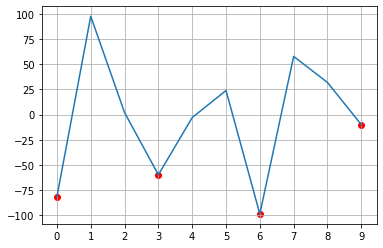

In [74]:
# функция поиска локальных минимумов
def arg_loc_mins(arr):
    mask_l = np.ones_like(arr, dtype=bool)
    mask_r = np.ones_like(arr, dtype=bool)
    mask = np.ones_like(arr, dtype=bool)
    mask_r[:-1] = arr[:-1] < arr[1:]
    mask_l[1:] = arr[1:] < arr[:-1]
    mask = mask_l * mask_r
    return np.where(mask)

N = 10
arr = np.random.randint(low=-100, high=100, size=N)
x = np.arange(N)
plt.plot(x, arr)
ids = arg_loc_mins(arr)
plt.scatter(x[ids], arr[ids], c='red')
plt.xticks(x);
plt.grid();

In [76]:
cv_RMSE_Cx_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,0])[0]
cv_MAE_Cx_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,2])[0]

cv_RMSE_Cy_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,1])[0]
cv_MAE_Cy_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,3])[0]

In [78]:
Cx_errs_argmin = np.intersect1d(cv_RMSE_Cx_argmin,cv_MAE_Cx_argmin)
Cy_errs_argmin = np.intersect1d(cv_RMSE_Cy_argmin,cv_MAE_Cy_argmin)

CxCy_errs_argmin = np.intersect1d(Cx_errs_argmin, Cy_errs_argmin)

In [79]:
print(Cx_errs_argmin)
print(Cy_errs_argmin)
print(CxCy_errs_argmin)

[ 0  2 11 14 20 23 26 32 38 42 45 47]
[ 1  6  9 11 13 20 22 28 35 47]
[11 20 47]


In [86]:
print("Cx_errs_min hyper-params")
for am in Cx_errs_argmin:
    print(f"{am} : theta0={kw_args_for_sm_list[am]['theta0']}, \
                    corr={kw_args_for_sm_list[am]['corr']},  \
                    poly={kw_args_for_sm_list[am]['poly']}")

print('___________________________________________________________________________________________________')
    
print("Cy_errs_min hyper-params")
for am in Cy_errs_argmin:
    print(f"{am} : theta0={kw_args_for_sm_list[am]['theta0']}, \
                    corr={kw_args_for_sm_list[am]['corr']}, \
                    poly={kw_args_for_sm_list[am]['poly']}")


print('___________________________________________________________________________________________________')

    
print("Cx_and_Cy_errs_min hyper-params")
for am in CxCy_errs_argmin:
    print(f"{am} : theta0={kw_args_for_sm_list[am]['theta0']}, \
                    corr={kw_args_for_sm_list[am]['corr']}, \
                    poly={kw_args_for_sm_list[am]['poly']}")

Cx_errs_min hyper-params
0 : theta0=[0.1],                     corr=squar_exp,                      poly=constant
2 : theta0=[0.1],                     corr=squar_exp,                      poly=quadratic
11 : theta0=[0.1],                     corr=matern52,                      poly=quadratic
14 : theta0=[1],                     corr=squar_exp,                      poly=quadratic
20 : theta0=[1],                     corr=matern32,                      poly=quadratic
23 : theta0=[1],                     corr=matern52,                      poly=quadratic
26 : theta0=[0.001],                     corr=squar_exp,                      poly=quadratic
32 : theta0=[0.001],                     corr=matern32,                      poly=quadratic
38 : theta0=[1e-06],                     corr=squar_exp,                      poly=quadratic
42 : theta0=[1e-06],                     corr=matern32,                      poly=constant
45 : theta0=[1e-06],                     corr=matern52,                 

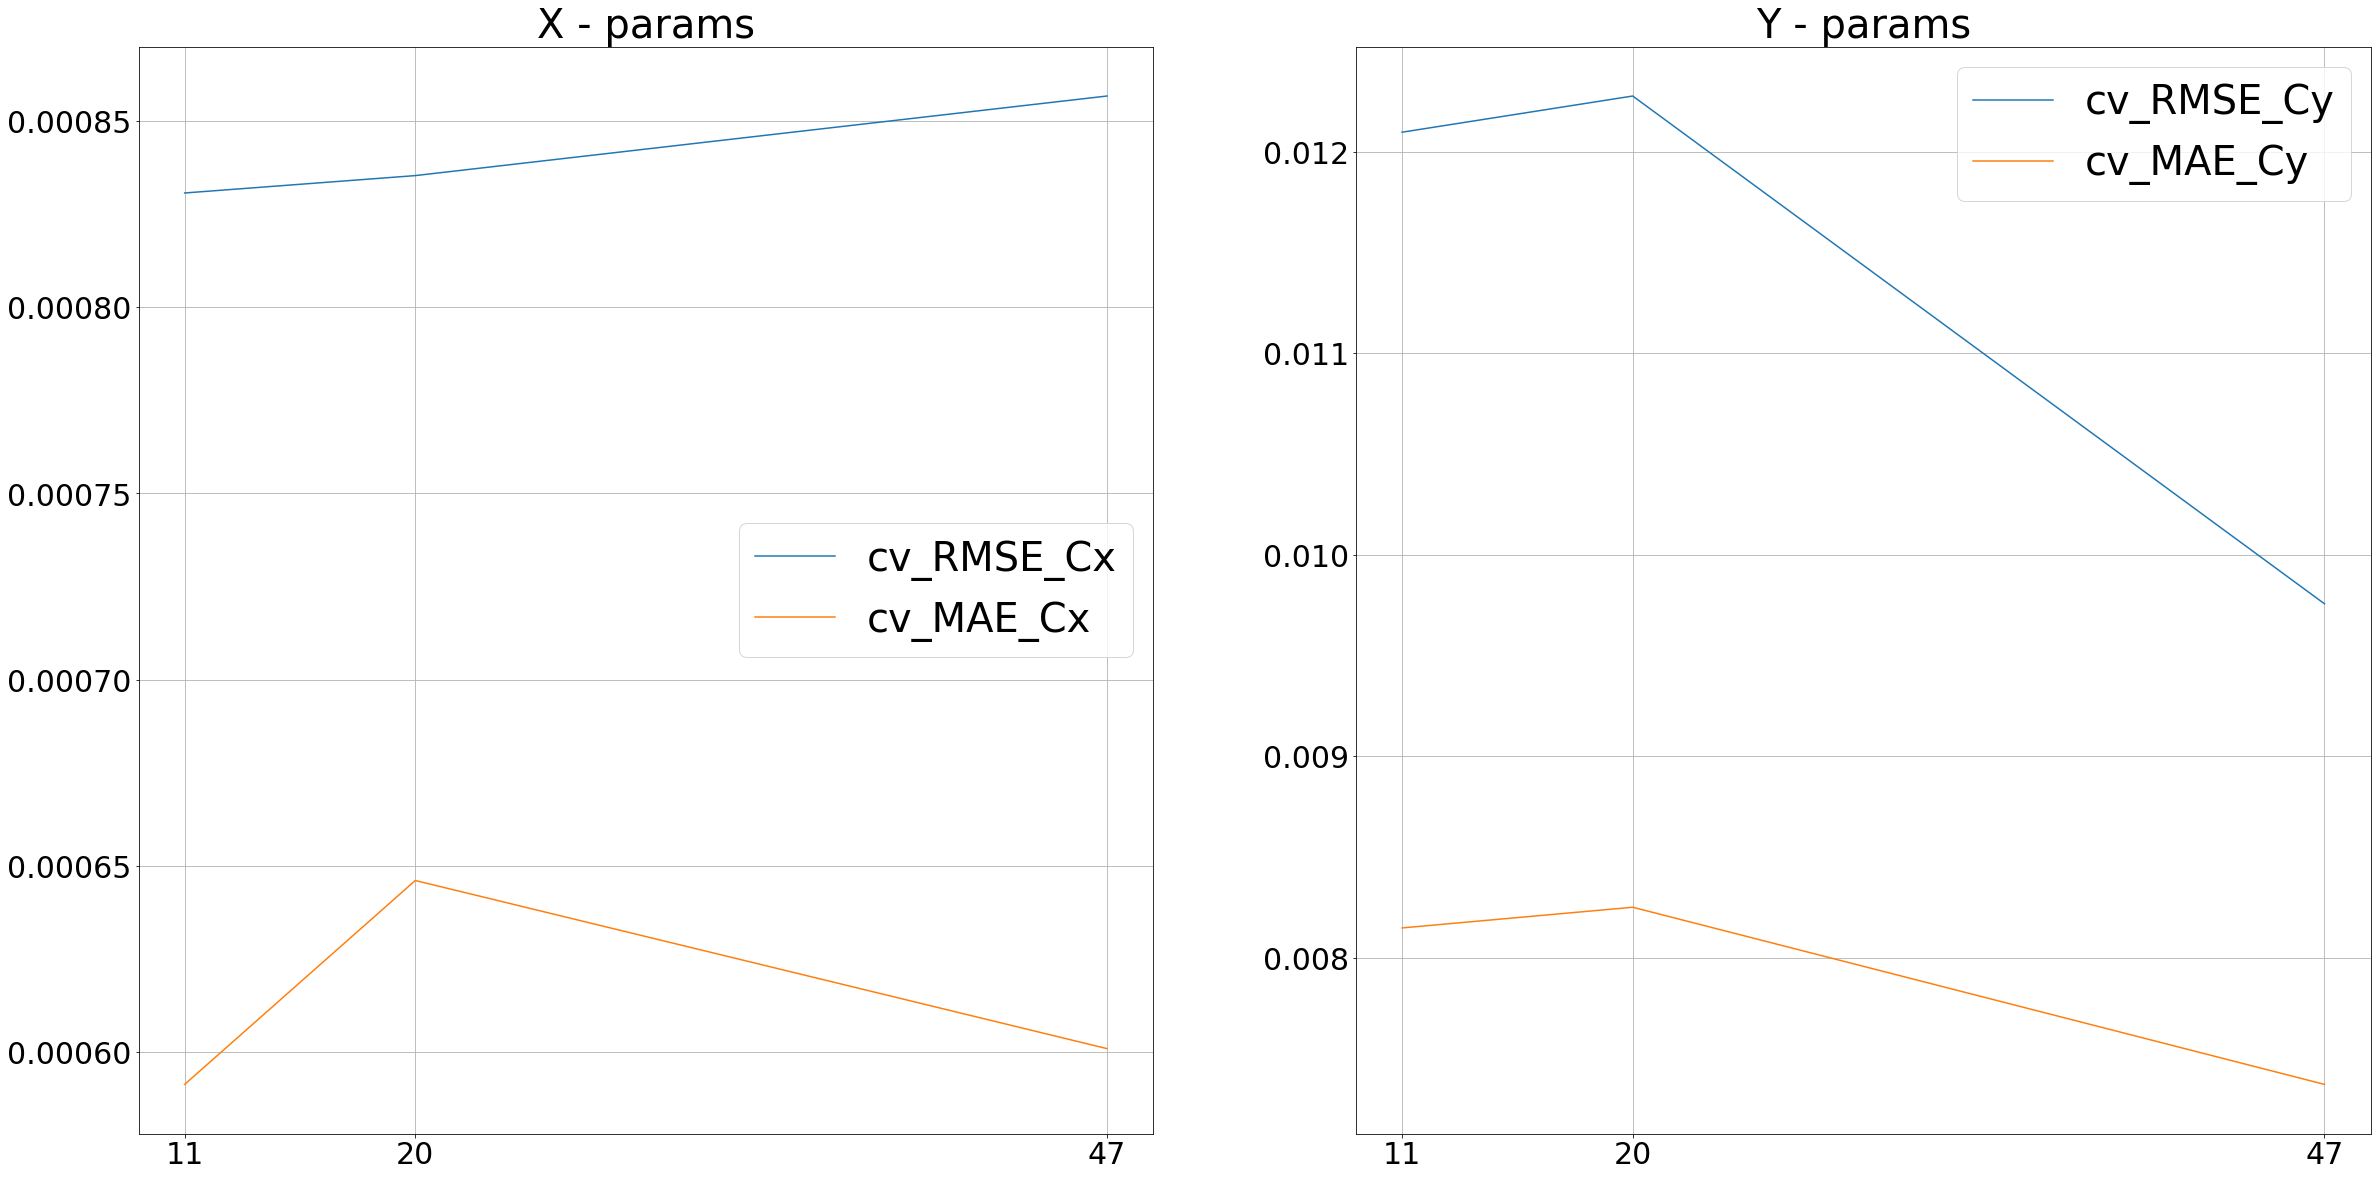

11 : {'print_global': False, 'theta0': [0.1], 'corr': 'matern52', 'poly': 'quadratic'}
20 : {'print_global': False, 'theta0': [1], 'corr': 'matern32', 'poly': 'quadratic'}
47 : {'print_global': False, 'theta0': [1e-06], 'corr': 'matern52', 'poly': 'quadratic'}


In [92]:
x = CxCy_errs_argmin
size = 20
plt.figure(figsize=(2*size,size))

plt.subplot(1, 2, 1)
plt.title("X - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[x,0], label='cv_RMSE_Cx')
plt.plot(x, MEAN_CROSS_ERRS[x,2], label='cv_MAE_Cx')
plt.xticks(x)
plt.tick_params(labelsize=size*3//2)
plt.grid()
plt.legend(fontsize=size*2)

plt.subplot(1, 2, 2)
plt.title("Y - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[x,1], label='cv_RMSE_Cy')
plt.plot(x, MEAN_CROSS_ERRS[x,3], label='cv_MAE_Cy')
plt.xticks(x)
plt.tick_params(labelsize=size*3//2)
plt.grid()
plt.legend(fontsize=size*2)

plt.show()
for num in x:
    print(f'{num} : {kw_args_for_sm_list[num]}')

Таким образом, лучшие результаты показывает квадратичный тренд с ядром корреляции `matern52`

In [99]:
n_splits = 8

kw_args_for_sm = {
    'print_global' : False,
    'theta0' : [1],
    'corr' : 'matern52',
    'poly' : 'quadratic'
    }

model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                             list_kw_args=kw_args_for_sm, 
                             coef_for_predict=coef_for_predict, 
                             debug=False)

cross_val = KFold(n_splits=n_splits, shuffle=True) #можно использовать другие методы валидации 
ERRORS = []
for train, test in cross_val.split(regimes):
    train_regimes, test_regimes = regimes.iloc[train], regimes.iloc[test] 
    train_FC, test_FC = total_FC.iloc[train], total_FC.iloc[test]

    model.fit(regimes=train_regimes, target=train_FC)

    pred_FC = model.predict(regimes=test_regimes)
    errors = np.array(CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=False))
    ERRORS.append(errors)
    
ERRORS = np.array(ERRORS)
if True:
    print(' |-RMSE_Cx--|-RMSE_Cy--|--MAE_Cx--|--MAE_Cy--|\n _____________________________________________\n',ERRORS)
    print('MEANS:\n', np.mean(ERRORS, axis=0), end='\n\n||||||||||||||||||||||||||||||||||||||||||||||\n\n')

 |-RMSE_Cx--|-RMSE_Cy--|--MAE_Cx--|--MAE_Cy--|
 _____________________________________________
 [[0.00124651 0.0112582  0.00081435 0.00832103]
 [0.00048804 0.00680854 0.00033754 0.00530986]
 [0.00075156 0.01116241 0.00052931 0.00817608]
 [0.00036085 0.01211596 0.00026392 0.0065292 ]
 [0.00018934 0.01612949 0.00016843 0.00964658]
 [0.00132824 0.01480883 0.00087219 0.01012461]
 [0.00048953 0.01093375 0.0004061  0.0089266 ]
 [0.0006949  0.00759334 0.00050731 0.00641479]]
MEANS:
 [0.00069362 0.01135131 0.00048739 0.0079311 ]

||||||||||||||||||||||||||||||||||||||||||||||



### Добавим шум

In [117]:
kw_args_for_sm_list = []
for el in itertools.product(
    noise0_list, 
    theta0_list, 
    corr_list, 
    poly_list
):
    
    kw = {
    'print_global' : False,
    'noise0' : [el[0]],
    'theta0' : [el[1]],
    'corr' : el[2],
    'poly' : el[3],
    }
    kw_args_for_sm_list.append(kw)

In [118]:
for i, kw in enumerate(kw_args_for_sm_list):
    print(f'[{i}]:{kw}')

[0]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'constant'}
[1]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'linear'}
[2]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'squar_exp', 'poly': 'quadratic'}
[3]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'constant'}
[4]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'linear'}
[5]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'abs_exp', 'poly': 'quadratic'}
[6]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'matern32', 'poly': 'constant'}
[7]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'matern32', 'poly': 'linear'}
[8]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'matern32', 'poly': 'quadratic'}
[9]:{'print_global': False, 'noise0': [0], 'theta0': [0.1], 'corr': 'matern52', 'poly': 'constant'}
[10

In [119]:
n_splits = 8
MEAN_CROSS_ERRS = []
for itrn, kw in enumerate(kw_args_for_sm_list):
    print(f'{itrn} / {len(kw_args_for_sm_list)-1} : ',kw, end='\r')    
        
    model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                                 list_kw_args=kw, 
                                 coef_for_predict=coef_for_predict, 
                                 debug=False)
    
    cross_val = KFold(n_splits=n_splits, shuffle=True) #можно использовать другие методы валидации 
    ERRORS = []
    for train, test in cross_val.split(regimes):
        train_regimes, test_regimes = regimes.iloc[train], regimes.iloc[test] 
        train_FC, test_FC = total_FC.iloc[train], total_FC.iloc[test]
        
        model.fit(regimes=train_regimes, target=train_FC)

        pred_FC = model.predict(regimes=test_regimes)
        errors = np.array(CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=False))
        ERRORS.append(errors)
    ERRORS = np.array(ERRORS)
    MEAN_CROSS_ERRS.append(np.mean(ERRORS, axis=0))

In [121]:
MEAN_CROSS_ERRS = np.array(MEAN_CROSS_ERRS)
# MEAN_CROSS_ERRS

In [122]:
cv_RMSE_Cx_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,0])[0]
cv_MAE_Cx_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,2])[0]

cv_RMSE_Cy_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,1])[0]
cv_MAE_Cy_argmin = arg_loc_mins(MEAN_CROSS_ERRS[:,3])[0]

In [123]:
Cx_errs_argmin = np.intersect1d(cv_RMSE_Cx_argmin,cv_MAE_Cx_argmin)
Cy_errs_argmin = np.intersect1d(cv_RMSE_Cy_argmin,cv_MAE_Cy_argmin)

CxCy_errs_argmin = np.intersect1d(Cx_errs_argmin, Cy_errs_argmin)

In [124]:
print(Cx_errs_argmin)
print(Cy_errs_argmin)
print(CxCy_errs_argmin)

[  2   6   9  18  20  23  26  30  32  35  38  44  47  50  56  59  62  68
  71  74  80  83  85  95  98 104 107 110 114 116 119 122 128 131 134 140
 143]
[  1   6   8  11  13  23  25  28  30  33  35  37  45  47  50  57  59  62
  67  70  78  81  86  93  95  98 105 110 114 119 122 127 131 134 136 141
 143]
[  6  23  30  35  47  50  59  62  95  98 110 114 119 122 131 134 143]


In [134]:
print("Cx_and_Cy_errs_min hyper-params")
for am in CxCy_errs_argmin:
    print(f"{am} :\ntheta0={kw_args_for_sm_list[am]['theta0']},",
          f"corr={kw_args_for_sm_list[am]['corr']}, poly={kw_args_for_sm_list[am]['poly']},",
          f"noise0={kw_args_for_sm_list[am]['noise0']}",
          f"\nMEAN_CROSS_ERRS = {MEAN_CROSS_ERRS[am]}", end='\n\n')

Cx_and_Cy_errs_min hyper-params
6 :
theta0=[0.1], corr=matern32, poly=constant, noise0=[0] 
MEAN_CROSS_ERRS = [0.00109038 0.01341026 0.00078754 0.00983779]

23 :
theta0=[1], corr=matern52, poly=quadratic, noise0=[0] 
MEAN_CROSS_ERRS = [0.00067987 0.01042142 0.0004911  0.00719684]

30 :
theta0=[0.001], corr=matern32, poly=constant, noise0=[0] 
MEAN_CROSS_ERRS = [0.00121229 0.01287905 0.00085602 0.00987859]

35 :
theta0=[0.001], corr=matern52, poly=quadratic, noise0=[0] 
MEAN_CROSS_ERRS = [0.00069503 0.01116224 0.00051947 0.00767511]

47 :
theta0=[1e-06], corr=matern52, poly=quadratic, noise0=[0] 
MEAN_CROSS_ERRS = [0.00088592 0.01225629 0.00056777 0.00800109]

50 :
theta0=[0.1], corr=squar_exp, poly=quadratic, noise0=[0.001] 
MEAN_CROSS_ERRS = [0.00085543 0.01013591 0.00061141 0.00623459]

59 :
theta0=[0.1], corr=matern52, poly=quadratic, noise0=[0.001] 
MEAN_CROSS_ERRS = [0.00100944 0.01322912 0.0007166  0.00880983]

62 :
theta0=[1], corr=squar_exp, poly=quadratic, noise0=[0.001] 
MEAN

### Сравним ядра

In [32]:
kw_args_for_sm_list = []
for el in itertools.product(
    [1e-6], 
    corr_list, 
    ['quadratic']
):
    
    kw = {
    'print_global' : False,
    'theta0' : [el[0]],
    'corr' : el[1],
    'poly' : el[2],
    }
    kw_args_for_sm_list.append(kw)
    
for i, kw in enumerate(kw_args_for_sm_list):
    print(f'[{i}]:{kw}')

[0]:{'print_global': False, 'theta0': [1e-06], 'corr': 'squar_exp', 'poly': 'quadratic'}
[1]:{'print_global': False, 'theta0': [1e-06], 'corr': 'abs_exp', 'poly': 'quadratic'}
[2]:{'print_global': False, 'theta0': [1e-06], 'corr': 'matern32', 'poly': 'quadratic'}
[3]:{'print_global': False, 'theta0': [1e-06], 'corr': 'matern52', 'poly': 'quadratic'}


In [33]:
n_splits = 8
MEAN_CROSS_ERRS = []
for itrn, kw in enumerate(kw_args_for_sm_list):
    print(f'{itrn} / {len(kw_args_for_sm_list)-1} : ',kw, end='\r')    
        
    model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                                 list_kw_args=kw, 
                                 coef_for_predict=coef_for_predict, 
                                 debug=False)
    
    cross_val = KFold(n_splits=n_splits, shuffle=True) #можно использовать другие методы валидации 
    ERRORS = []
    for train, test in cross_val.split(regimes):
        train_regimes, test_regimes = regimes.iloc[train], regimes.iloc[test] 
        train_FC, test_FC = total_FC.iloc[train], total_FC.iloc[test]
        
        model.fit(regimes=train_regimes, target=train_FC)

        pred_FC = model.predict(regimes=test_regimes)
        errors = np.array(CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=False))
        ERRORS.append(errors)
    ERRORS = np.array(ERRORS)
    MEAN_CROSS_ERRS.append(np.mean(ERRORS, axis=0))

In [34]:
MEAN_CROSS_ERRS = np.array(MEAN_CROSS_ERRS)
# MEAN_CROSS_ERRS

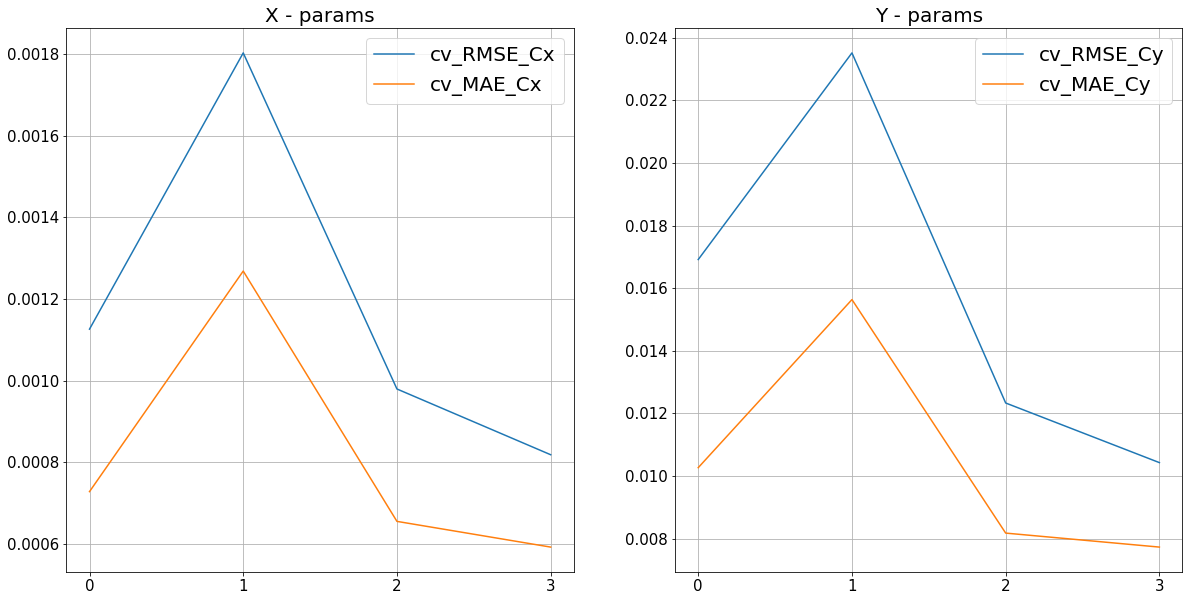

0 - {'print_global': False, 'theta0': [1e-06], 'corr': 'squar_exp', 'poly': 'quadratic'}
1 - {'print_global': False, 'theta0': [1e-06], 'corr': 'abs_exp', 'poly': 'quadratic'}
2 - {'print_global': False, 'theta0': [1e-06], 'corr': 'matern32', 'poly': 'quadratic'}
3 - {'print_global': False, 'theta0': [1e-06], 'corr': 'matern52', 'poly': 'quadratic'}


In [35]:
x = np.arange(MEAN_CROSS_ERRS.shape[0])
size = 10
plt.figure(figsize=(2*size,size))

plt.subplot(1, 2, 1)
plt.title("X - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[:,0], label='cv_RMSE_Cx')
plt.plot(x, MEAN_CROSS_ERRS[:,2], label='cv_MAE_Cx')
plt.xticks(x)
plt.tick_params(labelsize=size*3//2)

plt.grid()
plt.legend(fontsize=size*2)

plt.subplot(1, 2, 2)
plt.title("Y - params", size=size*2)
plt.plot(x, MEAN_CROSS_ERRS[:,1], label='cv_RMSE_Cy')
plt.plot(x, MEAN_CROSS_ERRS[:,3], label='cv_MAE_Cy')
plt.xticks(x)
plt.tick_params(labelsize=size*3//2)

plt.grid()
plt.legend(fontsize=size*2)

plt.show()

for num, hyp_param in zip(x, kw_args_for_sm_list):
    print(f'{num} - {hyp_param}')

таким образом, matern52 

In [43]:
total_FC.describe()

,Cx,Cy
count,64.000000,64.000000
mean,0.057428,0.371248
std,0.033607,0.370850
min,0.018641,-0.298906
25%,0.029461,0.048029
50%,0.048983,0.399485
75%,0.074504,0.729573
max,0.147154,0.915530


# Проверка точности разработанного метода

In [22]:
train_regimes, test_regimes, train_FC, test_FC = train_test_split(regimes, total_FC,test_size=56/64, random_state=42)

# выцепим нужную информацию для тестирования
test_regimes_index = test_regimes.index.to_numpy()
test_regimes_index

array([52, 58,  0, 44,  5, 36, 16, 12, 25, 61, 56,  9, 40, 13, 34, 50,  3,
       17, 49,  8,  6, 33,  4, 47, 19, 54, 41, 55, 31, 30, 59, 60, 15, 27,
       26, 24, 46, 11, 32, 57, 45, 37, 29, 43, 48,  1, 21,  2, 62, 39, 35,
       23, 53, 10, 22, 18])

In [23]:
kw_args_for_sm = {
    'print_global' : False,
    'theta0' : [0.1],
    'corr' : 'matern52',
    'poly' : 'quadratic'
    }
sm_names = ['KRG', 'KRG']
coef_for_predict = ["Cx", "Cy"]

model = mysol.CxCy_PREDICTOR(sm_names=sm_names,
                             list_kw_args=kw_args_for_sm, 
                             coef_for_predict=coef_for_predict, 
                             debug=False)
model.fit(regimes=train_regimes, target=train_FC)

pred_FC = model.predict(regimes=test_regimes)
errors = CxCy_quality(CxCy_true=test_FC, CxCy_pred=pred_FC, need_print=True)

RMSE_Cx = 0.008150617498376166
RMSE_Cy = 0.21952165047561775
MAE_Cx = 0.005156530577405465
MAE_Cy = 0.12837143337888593
